<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/SMOTE_schiz_models_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.3 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE

In [ ]:
def calculate_scores(model, givenx, giveny, xtest):
  kf = KFold(n_splits=10)
  crossval_f1 = cross_val_score(model, givenx, giveny, scoring='f1_macro', cv = kf)
  mean_score = crossval_f1.mean()
  std_score = crossval_f1.std()
  print('f1_macro', mean_score, '±', std_score)

  crossval_accuracy = cross_val_score(model, givenx, giveny, scoring='accuracy', cv = kf)
  mean_score = crossval_accuracy.mean()
  std_score = crossval_accuracy.std()
  print('accuracy', mean_score, '±', std_score)

  crossval_recall = cross_val_score(model, givenx, giveny, scoring='recall_macro', cv = kf)
  mean_score = crossval_recall.mean()
  std_score = crossval_recall.std()
  print('recall', mean_score, '±', std_score)

  if giveny.nunique() == 2:
    y_proba = model.predict_proba(xtest)
    print('roc_auc_score', roc_auc_score(y_test, y_proba[:,1]))

In [ ]:
def random_forest_class(xtrain, ytrain, xtest, ytest, xgiven, ygiven):
  warnings.filterwarnings('ignore')

  opt = BayesSearchCV(
      RandomForestClassifier(),
      {
          'n_estimators':  (100, 1000),
          'max_depth': (10, 100),
          'min_samples_split': np.linspace(0.0001, 1, 10),
          'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
      },
      scoring='f1_macro',
      n_iter=32,
      cv=3
  )

  opt.fit(xtrain, ytrain)

  print("val. score: %s" % opt.best_score_)
  print("test score: %s" % opt.score(xtest, ytest))
  print("best_params: %s" % opt.best_params_, '\n')

  rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
  rfc.fit(xtrain, ytrain)
  y_pred = rfc.predict(xtest)
  print(classification_report(ytest,y_pred), '\n')

  calculate_scores(rfc, xgiven, ygiven, xtest)

  sorted_idx = rfc.feature_importances_.argsort()
  feature_names = [f"feature {i}" for i in range(X.shape[1])]
  plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
  plt.xlabel("Random Forest Feature Importance")

In [ ]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [ ]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.9456537774277823
test score: 0.9709353754391286
best_params: OrderedDict([('max_depth', 10), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 100)]) 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.95      1.00      0.98        60
           2       1.00      1.00      1.00        65

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180
 

f1_macro 0.859996531105811 ± 0.18273255852975323
accuracy 0.9644444444444445 ± 0.04682512779045662
recall 0.897985079553707 ± 0.17221644758486254


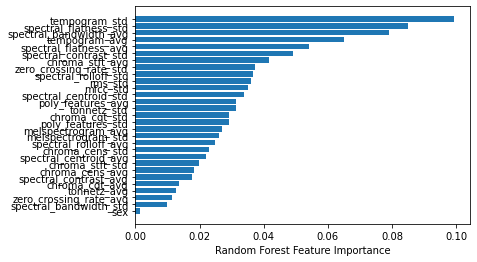

In [ ]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [ ]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.9038008139655674
test score: 0.9473786658223989
best_params: OrderedDict([('max_depth', 10), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 100)]) 

              precision    recall  f1-score   support

           0       0.94      0.85      0.90        55
           1       0.89      0.95      0.92        60
           2       0.98      1.00      0.99        65

    accuracy                           0.94       180
   macro avg       0.94      0.93      0.94       180
weighted avg       0.94      0.94      0.94       180
 

f1_macro 0.6759096000176492 ± 0.2527276878680795
accuracy 0.9355555555555556 ± 0.05833068777069639
recall 0.7177691952201756 ± 0.27370678103742735


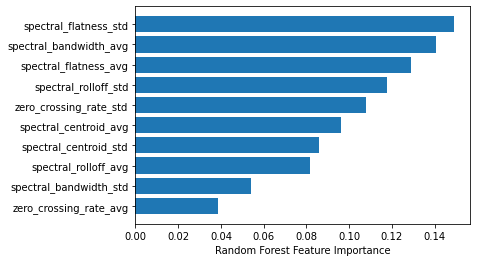

In [ ]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

**Binary**

All features

In [ ]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

val. score: 0.958261572963775
test score: 0.9832167832167833
best_params: OrderedDict([('max_depth', 100), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)]) 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.97      1.00      0.98        32

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60
 

f1_macro 0.8509585130698916 ± 0.1938996250696444
accuracy 0.9666666666666666 ± 0.033333333333333326
recall 0.8771257646030787 ± 0.20718128127545102
0.984375


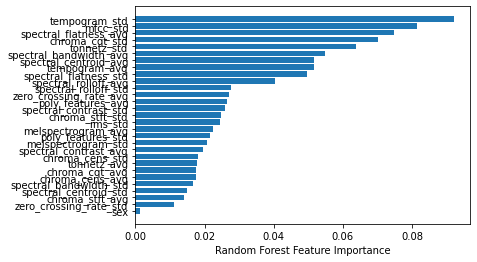

In [ ]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [ ]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.8543938549442353
test score: 0.8903801559974702
best_params: OrderedDict([('max_depth', 100), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 100)]) 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        55
           1       0.90      0.95      0.93        65

    accuracy                           0.92       120
   macro avg       0.92      0.91      0.92       120
weighted avg       0.92      0.92      0.92       120
 

f1_macro 0.6451224348327321 ± 0.20882177509586608
accuracy 0.9133333333333334 ± 0.06182412330330468
recall 0.6463727413273693 ± 0.22571561792343692
0.9690909090909091


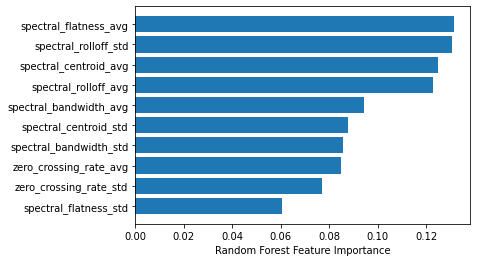

In [ ]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)